# 0.0 IMPORTS

In [73]:
import math
import pandas  as pd
import inflection
import seaborn as sns
import numpy   as np
import datetime


from scipy                 import stats  as ss
from IPython.display       import Image
from matplotlib            import pyplot as plt
from tabulate              import tabulate
from sklearn.preprocessing import RobustScaler, MinMaxScaler, LabelEncoder
from sklearn.ensemble      import RandomForestRegressor
from boruta                import BorutaPy
from IPython.display       import display, HTML

## 0.1 HELPER FUNCTIONS

In [74]:
sns.set(rc = {'figure.figsize':(15,15)})

In [75]:
def cramer_v(x, y):

    cm = pd.crosstab(x, y).values

    n = cm.sum()

    k,r = cm.shape
    
    chi2 = ss.chi2_contingency(cm)[0]
    chi2corr = max(0, chi2 - (k-1) * (r-1) / (n -1) )
    
    kcorr = k - (k-1)**2 / (n-1) 
    
    rcorr = r - (r-1)**2 / (n-1) 
    
    
    return np.sqrt ( ( chi2corr / n) / ( min (kcorr-1 ,rcorr-1 ) ) )

In [76]:
def jupyter_settings():
    %matplotlib inline

    plt.style.use('bmh')
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 24

    display(HTML('<style>.conteiner{width:100% !important;}</style>'))

    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option('display.expand_frame_repr', False)
    # configura o pandas para quantidade de casas decimeis
    pd.set_option('display.float_format', lambda x: '%.2f' % x)

    sns.set()
jupyter_settings()

## 0.2 LOADING DATA

In [77]:
df_sales_raw = pd.read_csv('data/train.csv', low_memory=False)
df_store_raw = pd.read_csv('data/store.csv', low_memory=False)

In [78]:
#Merge
df_raw = pd.merge(df_sales_raw, df_store_raw, how= 'left', on = 'Store')

#  1.0. PASSO 01 -  DESCRIÇÃO DE DADOS

In [79]:
df1 = df_raw.copy()

## 1.1 RENAME COLUMNS

In [80]:
cols_old = ['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
       'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'PromoInterval']

snakecase = lambda x: inflection.underscore(x)
cols_new = list(map( snakecase, cols_old))

#Rename

df1.columns = cols_new


## 1.2  DATA DIMENSIONS

In [81]:
datad1 = df1.shape[0]
datad2 = df1.shape[1]

print (f'Number of row: {datad1} ')
print (f'Number of Columns: {datad2} ')

Number of row: 1017209 
Number of Columns: 18 


## 1.3  DATA TYPES

In [82]:
df1 ['date'] = pd.to_datetime (df1['date'])
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
dtype: object

## 1.4  CHECK NA 

In [83]:
df1.isna().sum()

store                                0
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
store_type                           0
assortment                           0
competition_distance              2642
competition_open_since_month    323348
competition_open_since_year     323348
promo2                               0
promo2_since_week               508031
promo2_since_year               508031
promo_interval                  508031
dtype: int64

## 1.5  FILLOUT NA 

In [84]:
# competition_distance              

df1['competition_distance'] = df1['competition_distance'].apply(lambda x: 200000.0 if math.isnan(x) else x)   

# competition_open_since_month    

df1['competition_open_since_month'] = df1.apply (lambda x: x['date'].month if math.isnan( x['competition_open_since_month']) else x['competition_open_since_month'], axis = 1)


# competition_open_since_year     
df1['competition_open_since_year'] = df1.apply (lambda x: x['date'].year if math.isnan( x['competition_open_since_year']) else x['competition_open_since_year'], axis = 1 )

# promo2_since_week               

df1['promo2_since_week'] = df1.apply (lambda x: x['date'].week if math.isnan( x['promo2_since_week']) else x['promo2_since_week'], axis = 1 )

# promo2_since_year               

df1['promo2_since_year'] = df1.apply (lambda x: x['date'].year if math.isnan( x['promo2_since_year']) else x['promo2_since_year'], axis = 1 )

# promo_interval  

month_map = {1: 'Jan', 2: 'Fev', 3: 'Mar', 4: 'Apr', 5: 'May', 6: 'Jun', 7: 'Jul', 8: 'Aug', 9: 'Sep', 10: 'Oct', 11: 'Nov', 12: 'Dec'}

df1['promo_interval'].fillna(0, inplace= True)

df1['month_map'] = df1['date'].dt.month.map(month_map)

df1['is_promo'] = df1[['promo_interval', 'month_map']].apply (lambda x: 0 if x['promo_interval'] == 0 else 1 if x['month_map'] in x['promo_interval'].split (',') else 0, axis = 1) 


## 1.6  CHANGE TYPES

In [85]:
df1['competition_open_since_month'] = df1['competition_open_since_month'].astype( int )
df1['competition_open_since_year'] = df1['competition_open_since_year'].astype( int )

df1['promo2_since_week'] = df1['promo2_since_week'].astype( int )
df1['promo2_since_year'] = df1['promo2_since_year'].astype( int )

## 1.7  DESCRIPTIVE STATISTICAL

In [86]:
num_attributes = df1.select_dtypes(include= ['int64', 'float64'])
cat_attributes = df1.select_dtypes(exclude= ['int64', 'float64', 'datetime64[ns]'])

## 1.7.1 NUMERICAL ATTRIBUTES

In [87]:
# Central Tendency - mean, median 

ct1 = pd.DataFrame (num_attributes.apply(np.mean)).T
ct2 = pd.DataFrame (num_attributes.apply(np.median)).T

# Dispersion - min, max, std, skew, kurtosis, range 
d1 = pd.DataFrame (num_attributes.apply( np.std ) ).T
d2 = pd.DataFrame (num_attributes.apply( min )).T
d3 = pd.DataFrame (num_attributes.apply( max )).T
d4 = pd.DataFrame (num_attributes.apply( lambda x: x.max() - x.min() )).T
d5 = pd.DataFrame (num_attributes.apply( lambda x: x.skew() ) ).T
d6 = pd.DataFrame (num_attributes.apply( lambda x: x.kurtosis() ) ).T


#Concatena 

m = pd.concat([d2, d3, d4, ct1, ct2, d1, d5, d6]).T.reset_index()

m.columns = ['attributes', 'min', 'max','range', 'mean', 'median','std', 'skew', 'kurtosis']

m




,attributes,min,max,range,mean,median,std,skew,kurtosis
0,store,1.00,1115.00,1114.00,558.43,558.00,321.91,-0.00,-1.20
1,day_of_week,1.00,7.00,6.00,4.00,4.00,2.00,0.00,-1.25
2,sales,0.00,41551.00,41551.00,5773.82,5744.00,3849.92,0.64,1.78
3,customers,0.00,7388.00,7388.00,633.15,609.00,464.41,1.60,7.09
4,open,0.00,1.00,1.00,0.83,1.00,0.38,-1.76,1.09
5,promo,0.00,1.00,1.00,0.38,0.00,0.49,0.49,-1.76
6,school_holiday,0.00,1.00,1.00,0.18,0.00,0.38,1.68,0.82
7,competition_distance,20.00,200000.00,199980.00,5935.44,2330.00,12547.65,10.24,147.79
8,competition_open_since_month,1.00,12.00,11.00,6.79,7.00,3.31,-0.04,-1.23
9,competition_open_since_year,1900.00,2015.00,115.00,2010.32,2012.00,5.52,-7.24,124.07


## 1.7.2  CATEGORICAL ATTRIBUTES 

In [88]:
cat_attributes.apply(lambda x: x.unique().shape[0])

state_holiday      4
store_type         4
assortment         3
promo_interval     4
month_map         12
dtype: int64

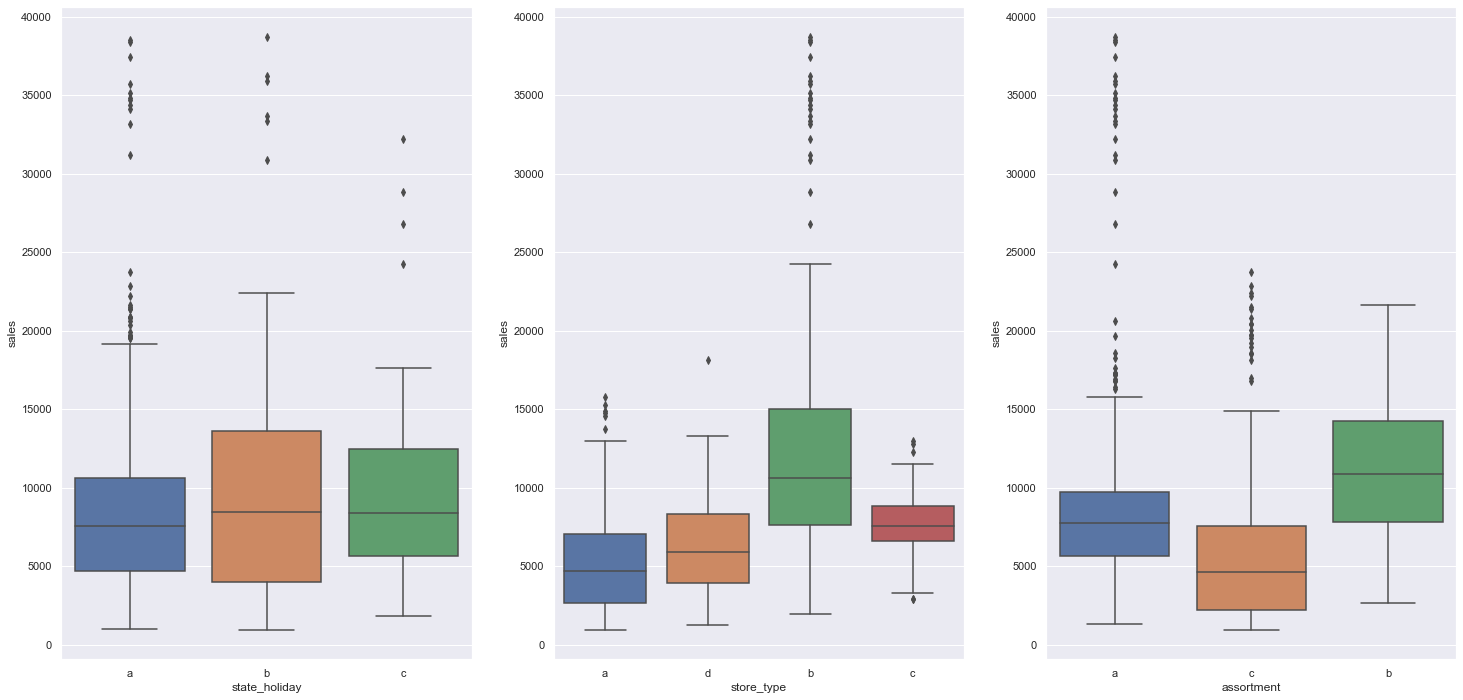

In [89]:
aux1 = df1[(df1['state_holiday'] != '0') & (df1['sales'] > 0)]

plt.subplot (1,3,1)
sns.boxplot( x= 'state_holiday', y='sales', data= aux1)

plt.subplot (1,3,2)
sns.boxplot( x= 'store_type', y='sales', data= aux1)

plt.subplot (1,3,3)
sns.boxplot( x= 'assortment', y='sales', data= aux1);



# 2.0. PASSO 02 - FEATURE ENGINEERING

In [90]:
df2 = df1.copy()

In [91]:
df2.shape

(1017209, 20)

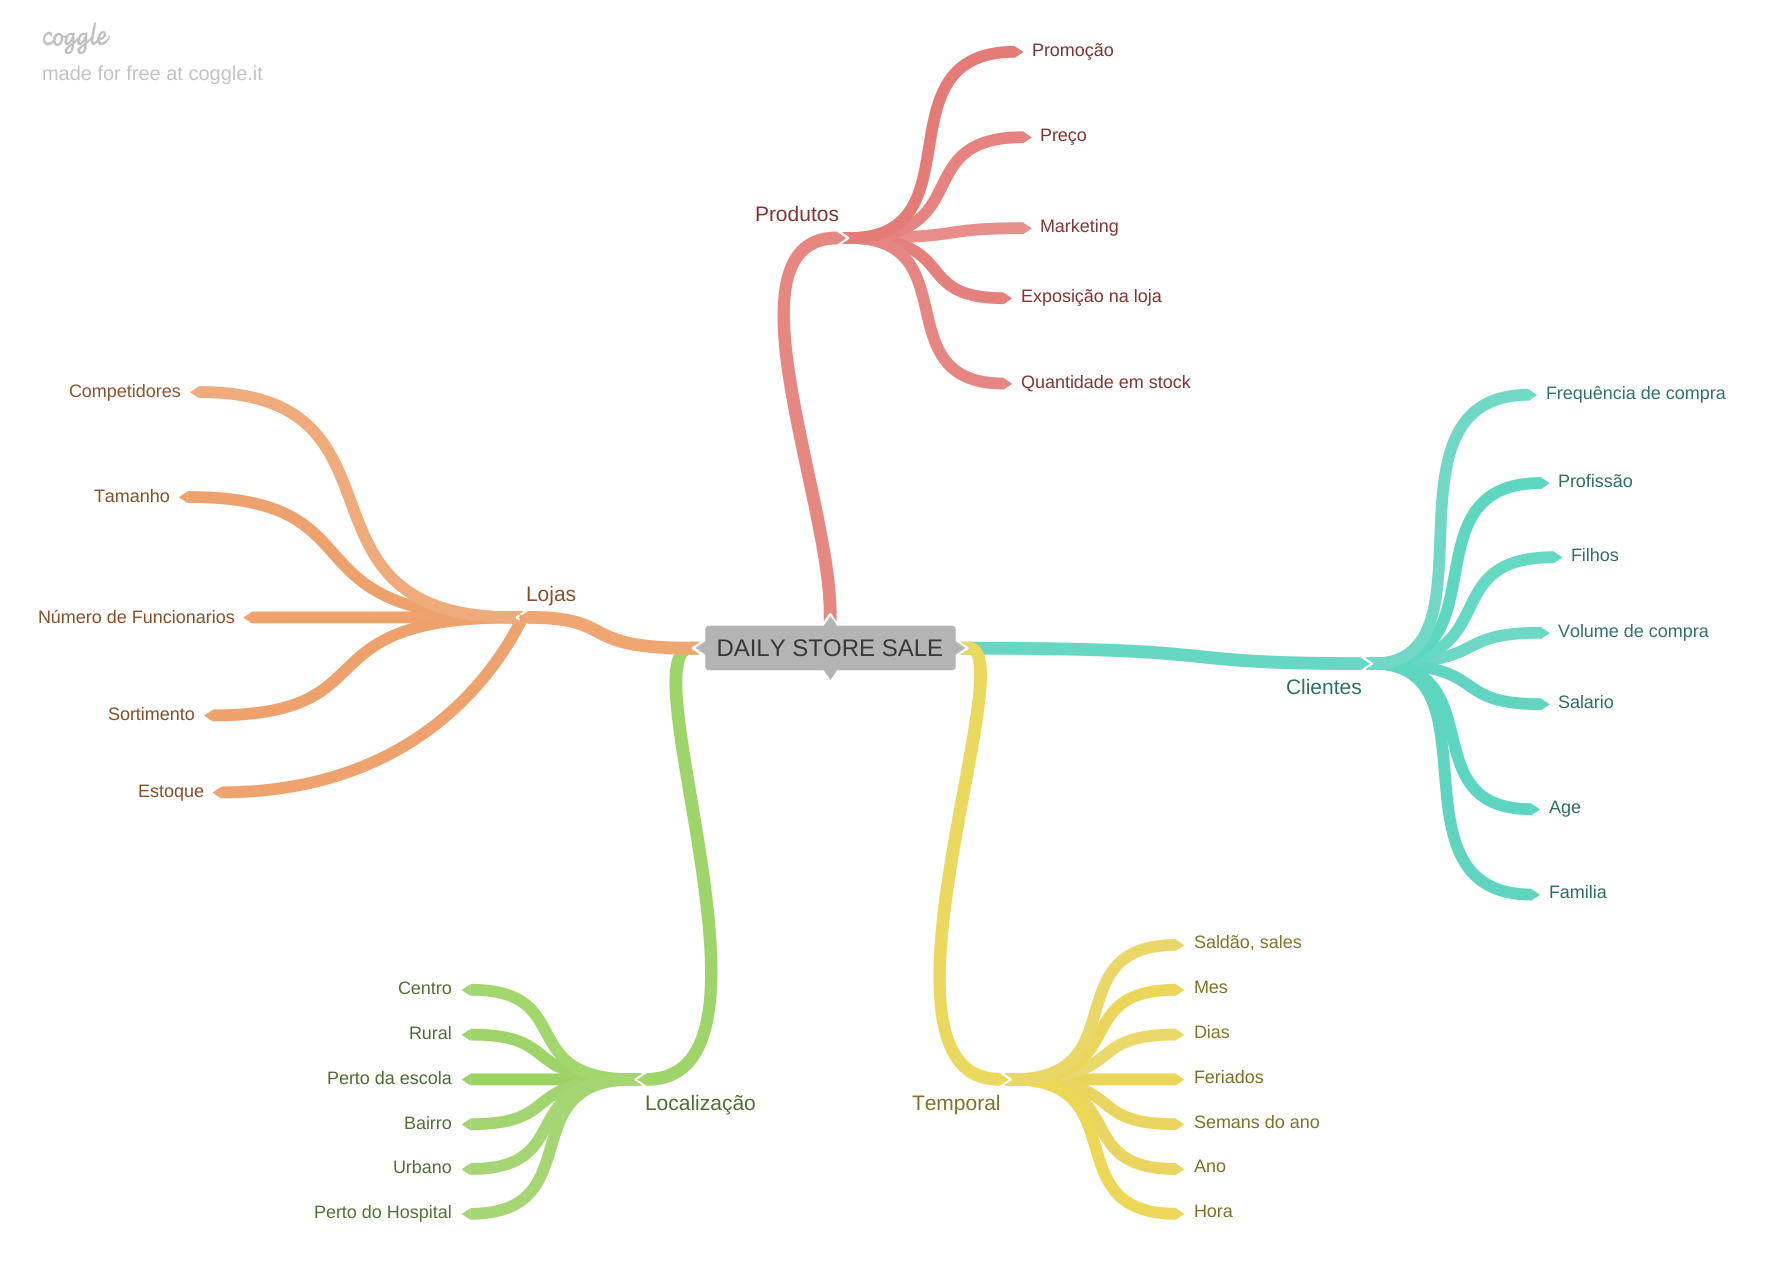

In [92]:
Image ('img/MindMap.png')

## 2.1 CRIANDO HIPOTESES

### 2.1.1 HIPOTESES LOJA

**1.** Lojas com um numero maior de funcionarios deveriam vender mais.

**2.** Lojas com maior capacidade de estoque deveriam vender mais.

**3.** Lojas com maior porte deveriam vender mais.

**4.** Lojas com maior sortimentos deveriam vender mais.

**5.** Lojas com competidores mais perto deveriam vender menos.

**6.** Lojas com competidores a mais tempo deveriam vender mais.


### 2.1.2 HIPOTESES PRODUTO 

**1.** Lojas que invesem mais em Marketing deveriam vender mais.

**2.** Lojas com maior exposição de produtos deveriam vender mais.

**3.** Lojas com produtos com preço menor deveriam vender mais.

**4.** Lojas com promoções mais agressivas, deveriam vender mais.

**5.** Lojas com promoções ativas por mais tempo, deveriam vender mais.

**6.** Lojas com mais dias de promoção deveriam vender mais.

**7.** Lojas com mais promoções consecutivas deveriam vender mais.



### 2.1.1  HIPOTESES TEMPO 

**1.** Lojas abertas durante o feriado de Natal deveriam vender mais.

**2.** Lojas  deveriam vender mais ao longo do anos.

**3.** Lojas  deveriam vender mais no segundo semestre do ano.

**4.** Lojas  deveriam vender mais depois do dia 10 de cada mês.

**5.** Lojas  deveriam vender menos aos finais de semana.

**6.** Lojas  deveriam vender menos durante os feriados escolares.

## 2.2 LISTA FINAL DE HIPOTESES

**1.** Lojas com maior sortimentos deveriam vender mais.

**2.** Lojas com competidores mais perto deveriam vender menos.

**3.** Lojas com competidores a mais tempo deveriam vender mais.

**4.** Lojas com promoções ativas por mais tempo, deveriam vender mais.

**5.** Lojas com mais dias de promoção deveriam vender mais.

**6.** Lojas com mais promoções consecutivas deveriam vender mais.

**7.** Lojas abertas durante o feriado de Natal deveriam vender mais.

**8.** Lojas  deveriam vender mais ao longo do anos.

**9.** Lojas  deveriam vender mais no segundo semestre do ano.

**10.** Lojas  deveriam vender mais depois do dia 10 de cada mês.

**11.** Lojas  deveriam vender menos aos finais de semana.

**12.** Lojas  deveriam vender menos durante os feriados escolares.




## 2.3 FEATURE ENGINEERING

In [93]:
# year
df2['year'] = df2['date'].dt.year

# month 
df2['month'] = df2['date'].dt.month

# day
df2['day'] = df2['date'].dt.day

# week of year
df2['week_of_year'] = df2['date'].dt.isocalendar().week
df2['week_of_year'] = df2['week_of_year'].astype( int )
# year week 
df2['year_week'] = df2['date'].dt.strftime('%Y-%W')



# competition since
df2['competition_since'] = df2.apply(lambda x: datetime.datetime( year= x['competition_open_since_year'], month= x['competition_open_since_month'], day= 1 ), axis = 1) 

df2['competition_time_month'] = (( df2['date'] - df2 ['competition_since'])/30 ).apply (lambda x: x.days).astype(int)


# promo since
df2['promo_since'] = df2['promo2_since_year'].astype(str) + '-' + df2['promo2_since_week'].astype(str)

df2['promo_since'] = df2['promo_since'].apply(lambda x: datetime.datetime.strptime(x + '-1', '%Y-%W-%w') - datetime.timedelta(days = 7) )

df2['promo_time_week'] = ((df2['date'] - df2['promo_since'])/ 7).apply(lambda x: x.days).astype(int)


# assortment

df2 ['assortment'] = df2['assortment'].apply(lambda x: 'basic' if x == 'a' else 'extra' if x == 'b' else 'extended')

# state holiday

df2['state_holiday'] = df2['state_holiday'].apply(lambda x: 'public_holiday' if x == 'a' else 'easter_holiday' if x == 'b' else 'christmas' if x == 'c' else 'regular_day')



# 3.0. PASSO 03 - FILTRAGEM DE VARIÁVEIS

In [94]:
df3 = df2.copy()

In [95]:
df3.shape

(1017209, 29)

## 3.1 FILTRAGEM DAS LINHAS

In [96]:
df3 = df3[(df3['open'] != 0) & (df3['sales'] > 0)]

## 3.2 SELEÇÃO DAS COLUNAS

In [97]:
cols_drop = ['customers', 'open', 'promo_interval', 'month_map']

df3 = df3.drop(cols_drop, axis = 1)

# 4.0. PASSO 04 - EXPLORATORY DATA ANALYSIS

In [98]:
df4 = df3.copy()

In [99]:
df4.shape

(844338, 25)

## 4.1 ANALISE UNIVARIADA

### 4.1.1 RESPONSE VARIABLE

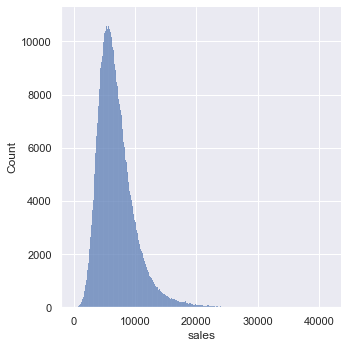

In [100]:
sns.displot(df4['sales'], kde = False);

### 4.1.2 NUMERICAL VARIABLE

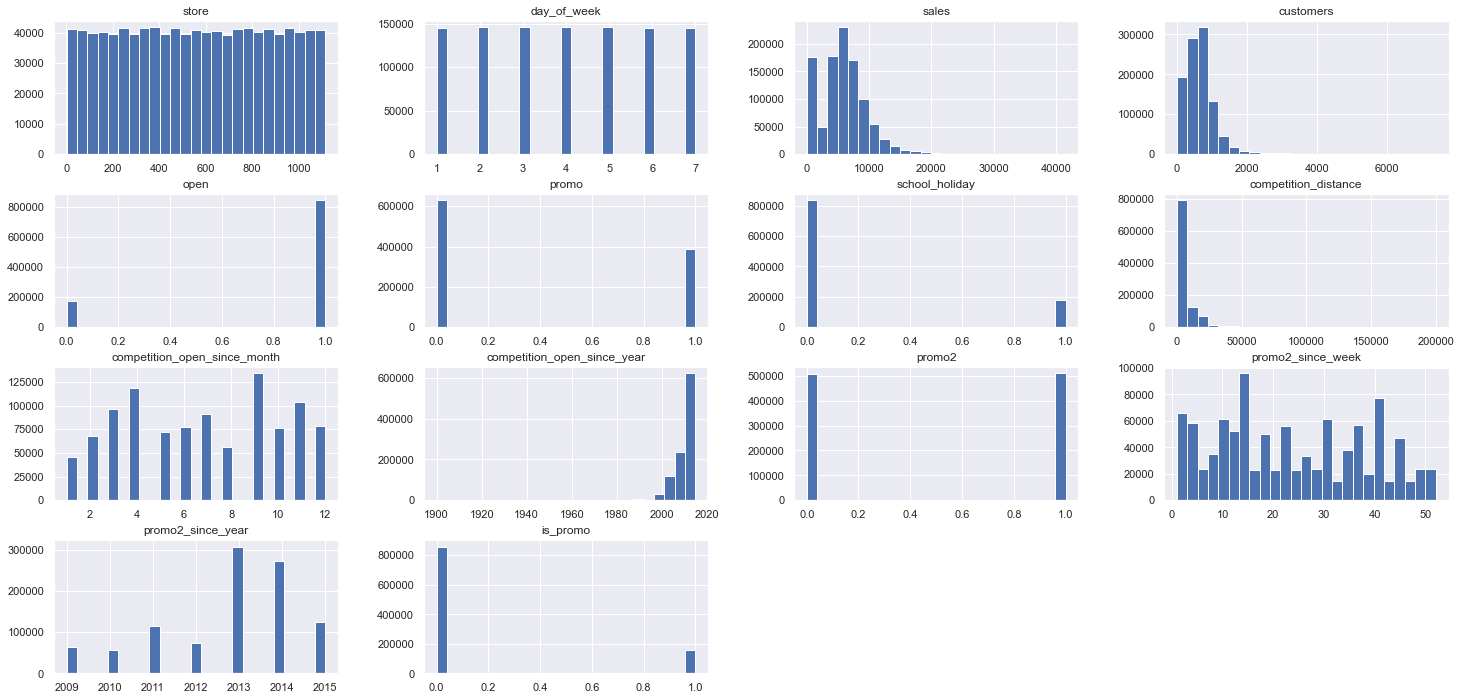

In [101]:
num_attributes.hist(bins = 25);

### 4.1.3 CATEGORICAL VARIABLE

In [102]:
df4['assortment'].drop_duplicates()

0         basic
3      extended
258       extra
Name: assortment, dtype: object

/home/israel/.pyenv/versions/3.10.4/envs/test1/lib/python3.10/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/israel/.pyenv/versions/3.10.4/envs/test1/lib/python3.10/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/israel/.pyenv/versions/3.10.4/envs/test1/lib/python3.10/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit key

<AxesSubplot:xlabel='sales', ylabel='Density'>

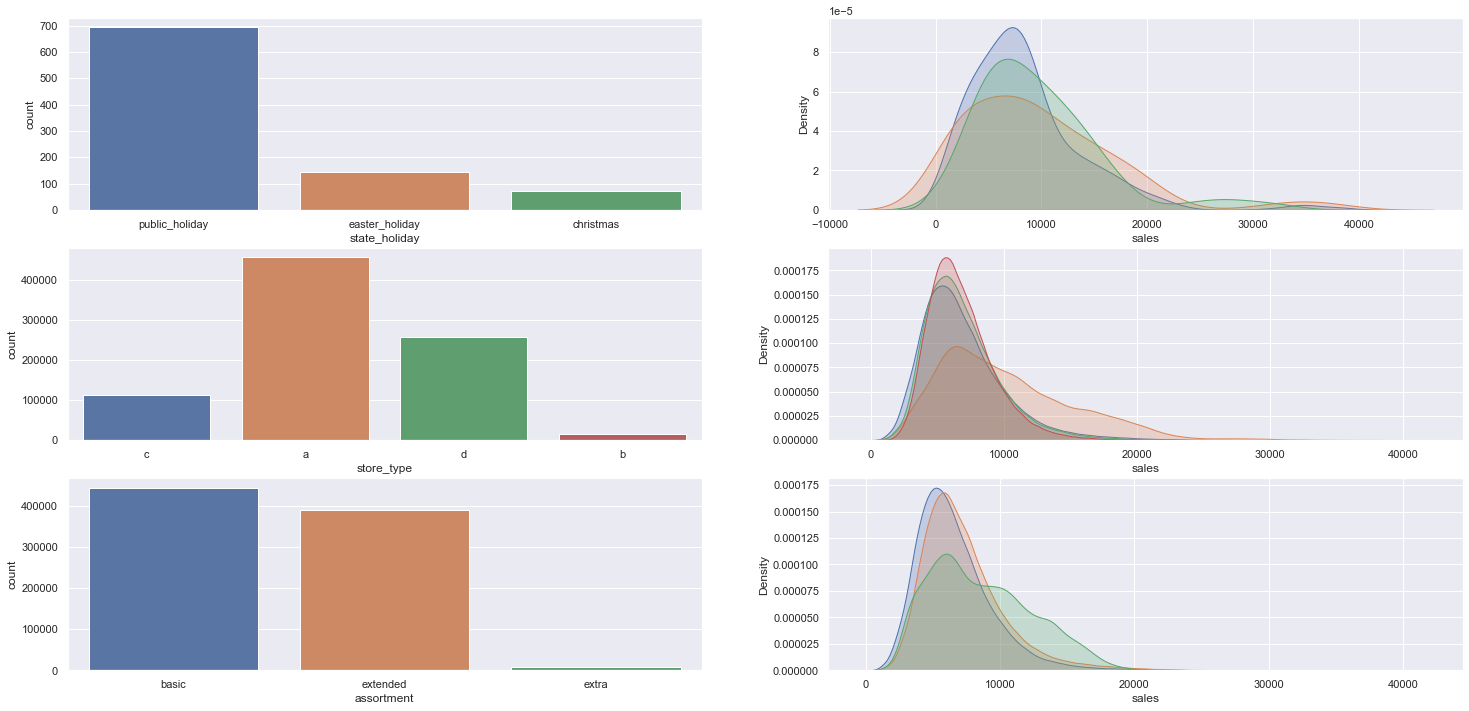

In [103]:
#state_holiday 

plt.subplot(3, 2, 1)
a = df4[df4['state_holiday'] != 'regular_day']
sns.countplot(a['state_holiday'])

plt.subplot(3, 2, 2)
sns.kdeplot(df4[df4['state_holiday'] == 'public_holiday']['sales'], label = 'public_holiday', shade = True)
sns.kdeplot(df4[df4['state_holiday'] == 'easter_holiday']['sales'], label = 'easter_holiday', shade = True)
sns.kdeplot(df4[df4['state_holiday'] == 'christmas']['sales'], label = 'christmas', shade = True)

#store_type

plt.subplot(3, 2, 3)
sns.countplot(df4['store_type'])

plt.subplot(3, 2, 4)
sns.kdeplot(df4[df4['store_type'] == 'a']['sales'], label = 'a', shade = True)
sns.kdeplot(df4[df4['store_type'] == 'b']['sales'], label = 'b', shade = True)
sns.kdeplot(df4[df4['store_type'] == 'c']['sales'], label = 'c', shade = True)
sns.kdeplot(df4[df4['store_type'] == 'd']['sales'], label = 'd', shade = True)



#assortment
plt.subplot(3, 2, 5)
sns.countplot(df4['assortment'])

plt.subplot(3, 2, 6)
sns.kdeplot(df4[df4['assortment'] == 'basic']['sales'], label = 'basic', shade = True)
sns.kdeplot(df4[df4['assortment'] == 'extended']['sales'], label = 'extended', shade = True)
sns.kdeplot(df4[df4['assortment'] == 'extra']['sales'], label = 'extra', shade = True)





## 4.2  ANALISE BIVARIADA

### **H1.** Lojas com maior sortimentos deveriam vender mais.
***FALSE*** Lojas com MAIOR sortimentos vendem MENOS.

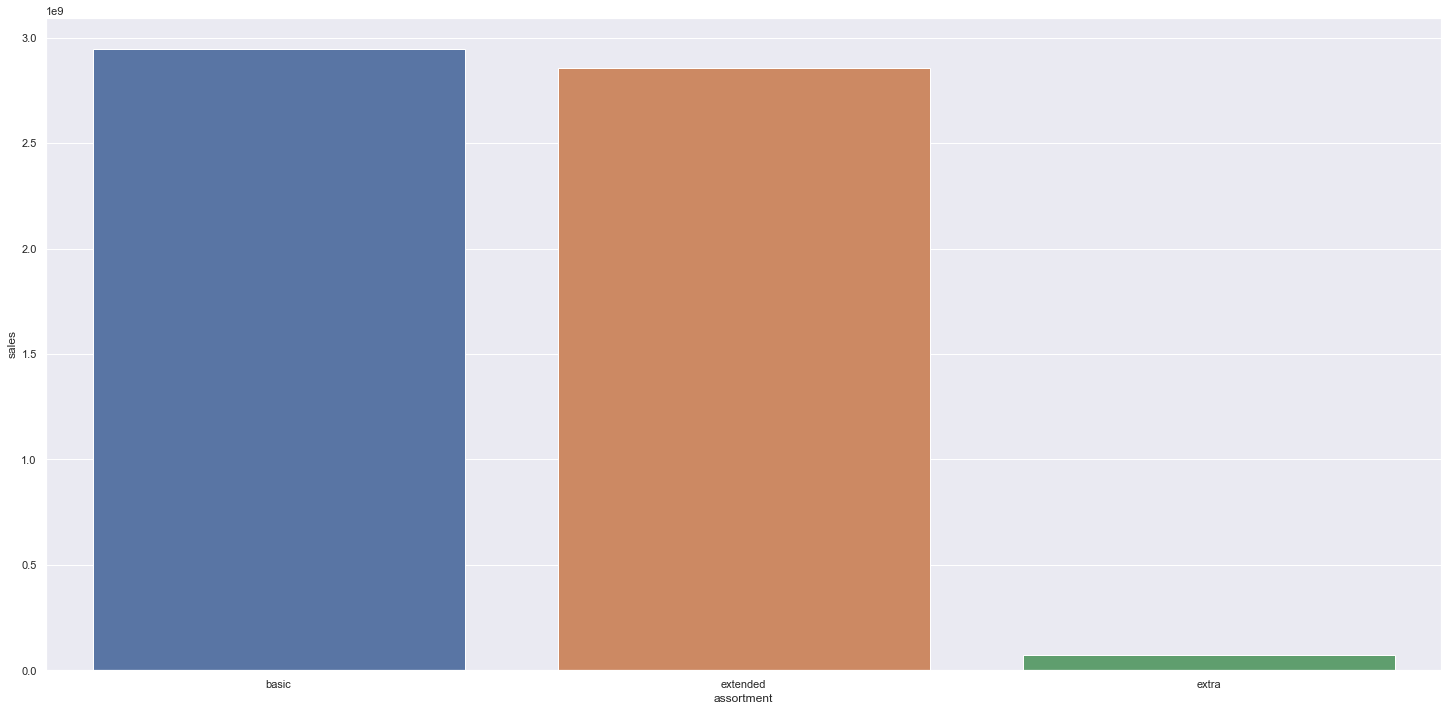

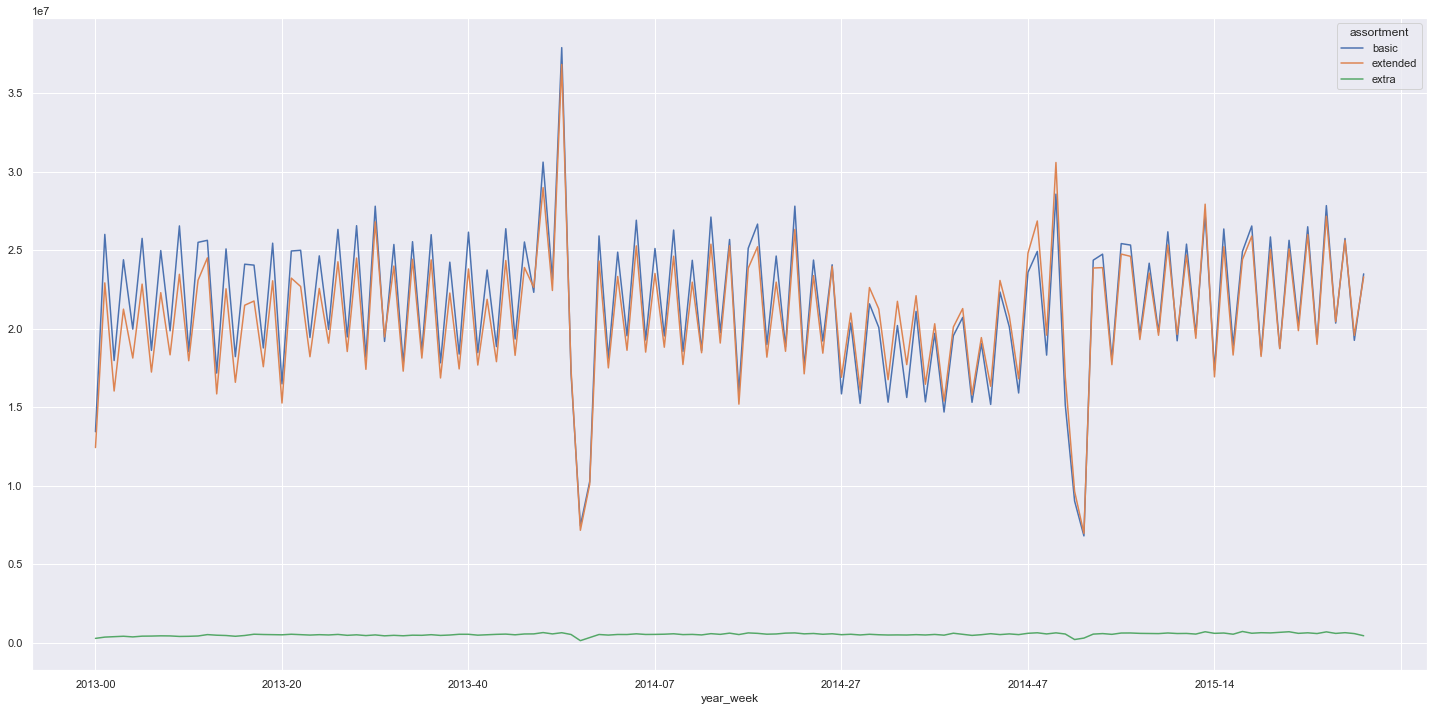

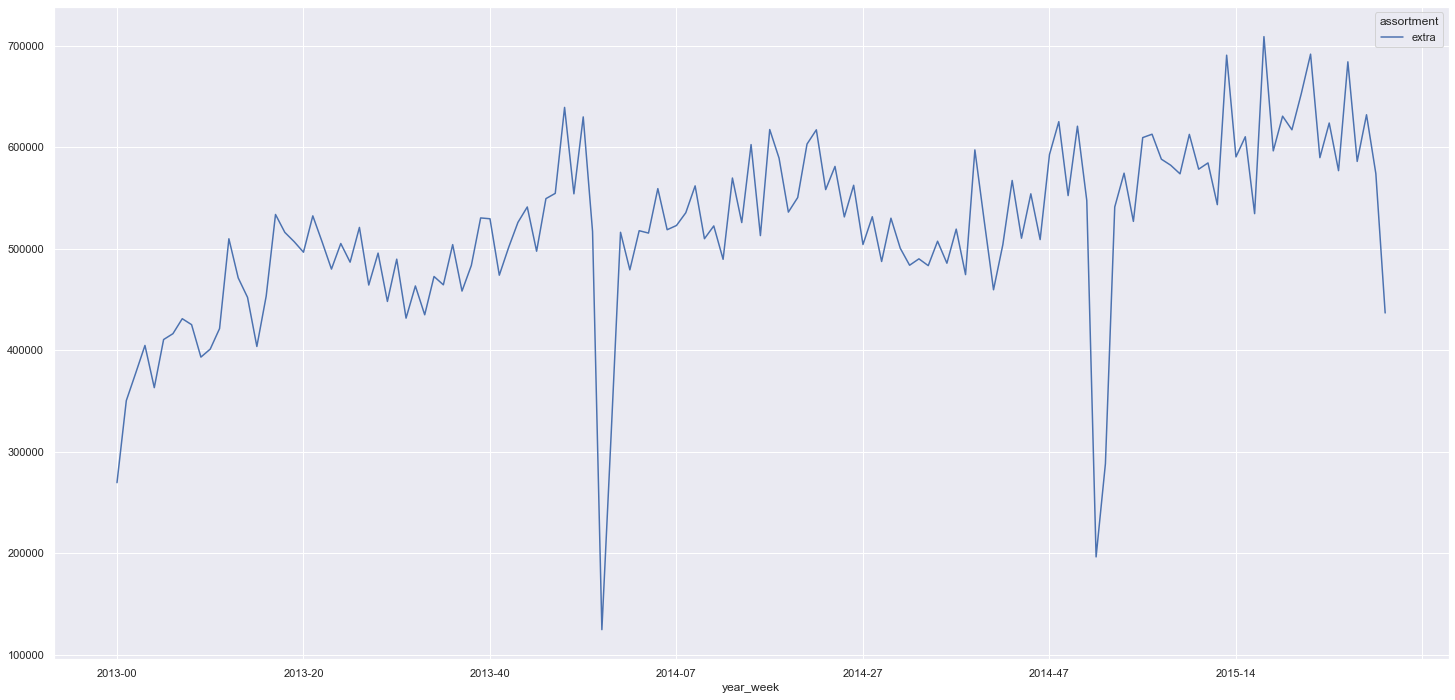

In [104]:
aux1 = df4[['assortment', 'sales']].groupby('assortment').sum().reset_index()
sns.barplot(x='assortment', y = 'sales', data = aux1)

aux2 = df4[['year_week','assortment', 'sales']].groupby(['year_week', 'assortment']).sum().reset_index()
aux2.pivot(index = 'year_week' , columns = 'assortment', values = 'sales').plot()

aux3 = aux2[aux2['assortment'] == 'extra']
aux3.pivot(index = 'year_week' , columns = 'assortment', values = 'sales').plot();



### **H2.** Lojas com competidores mais perto deveriam vender menos.
***FALSE*** Lojas com COMPETIDORES MAIS PERTO vendem MAIS. 

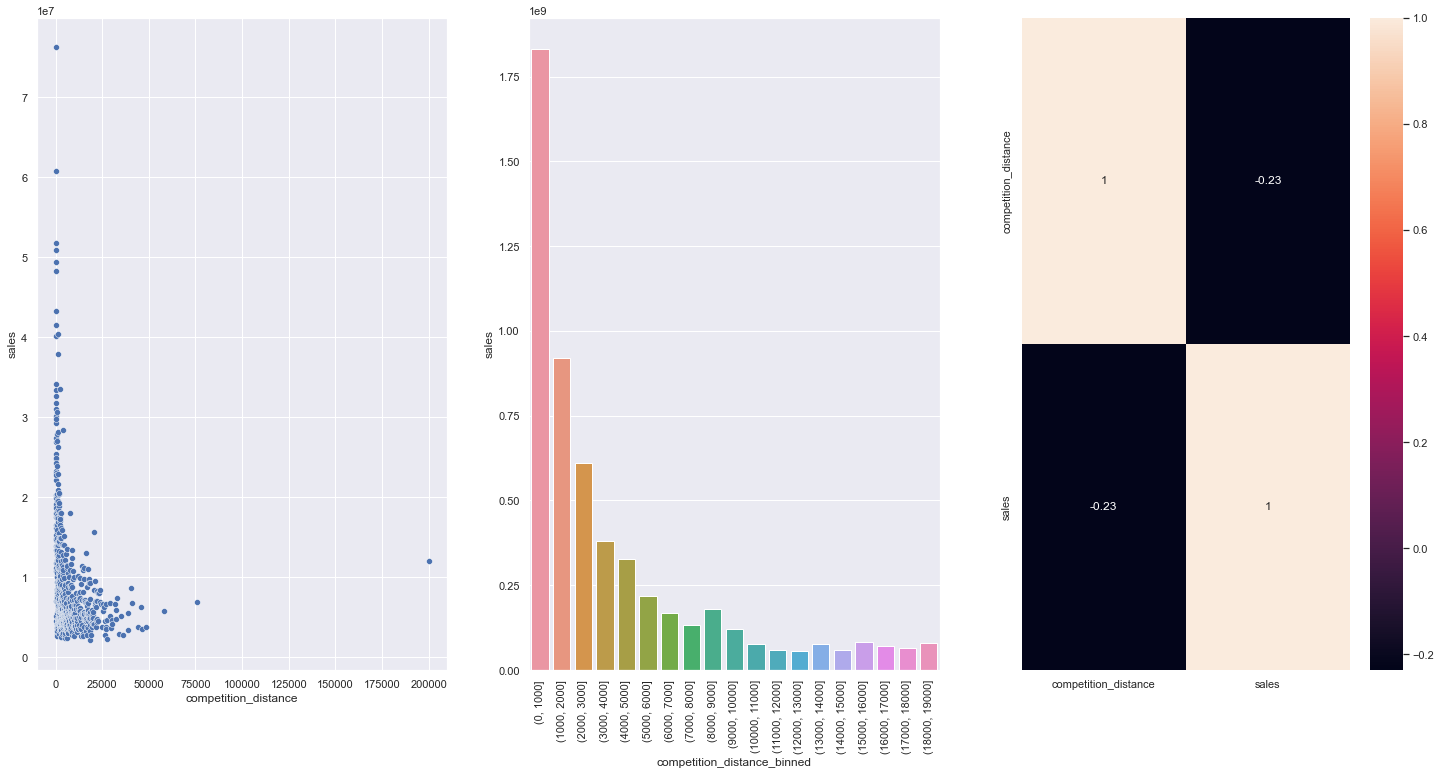

In [105]:
aux1 = df4[['competition_distance', 'sales']].groupby('competition_distance').sum().reset_index()

plt.subplot(1, 3, 1)
sns.scatterplot(x='competition_distance', y='sales', data = aux1)

plt.subplot(1, 3, 2)
bins = list (np.arange (0, 20000, 1000))
aux1['competition_distance_binned'] =  pd.cut(aux1['competition_distance'], bins = bins)
aux2 = aux1[['competition_distance_binned', 'sales']].groupby('competition_distance_binned').sum().reset_index()
sns.barplot(x='competition_distance_binned', y='sales', data = aux2);
plt.xticks (rotation = 90);

plt.subplot(1, 3, 3)
sns.heatmap(aux1.corr(method = 'pearson'),annot = True);




### **H3.** Lojas com competidores a mais tempo deveriam vender mais.
***FALSE*** Lojas com COMPETIDORES a mais tempo vendem MENOS.

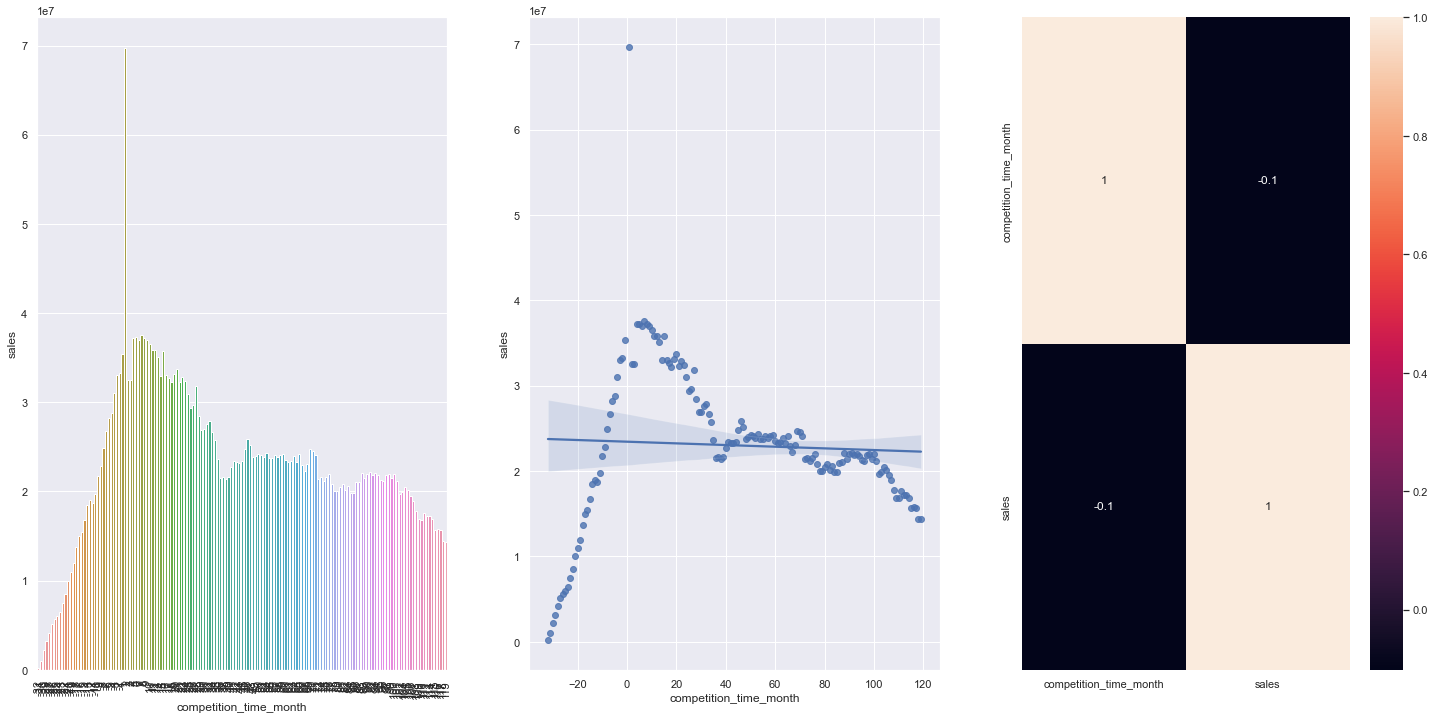

In [106]:
aux1 = df4[['competition_time_month', 'sales']].groupby('competition_time_month').sum().reset_index()
aux2 = aux1[(aux1['competition_time_month'] < 120) & (aux1['competition_time_month'] != 0)]

plt.subplot (1, 3, 1)
sns.barplot(x='competition_time_month', y='sales', data = aux2);
plt.xticks(rotation = 90);

plt.subplot (1, 3, 2)
sns.regplot (x= 'competition_time_month', y= 'sales', data = aux2)

plt.subplot (1, 3, 3)
sns.heatmap(aux1.corr (method = 'pearson'), annot= True);


### **H4.** Lojas com promoções ativas por mais tempo, deveriam vender mais.
***FALSE*** Lojas com promoções ativas por mais tempo vendem MENOS.

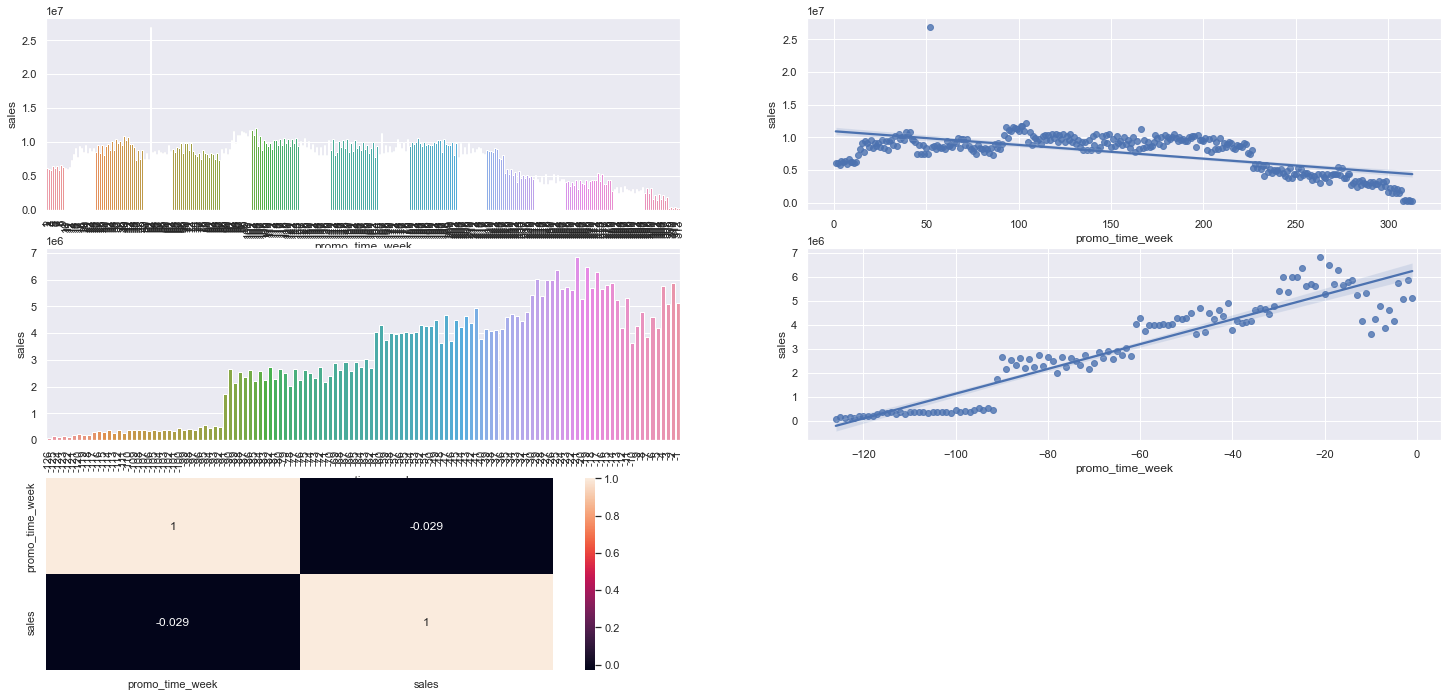

In [107]:
aux1 = df4[['promo_time_week', 'sales']].groupby('promo_time_week').sum().reset_index()
sns.barplot (x= 'promo_time_week',y = 'sales', data = aux1);


plt.subplot (3, 2, 1 )
aux2 = aux1[aux1['promo_time_week'] > 0] #promo extendido
sns.barplot (x= 'promo_time_week', y= 'sales', data=aux2);
plt.xticks(rotation =90);
             
plt.subplot (3, 2, 2)
sns.regplot(x= 'promo_time_week', y= 'sales', data=aux2);       
             
plt.subplot (3, 2, 3)
aux3 = aux1[aux1['promo_time_week'] < 0] #promo regular
sns.barplot (x= 'promo_time_week', y= 'sales', data=aux3);
plt.xticks(rotation= 90);

plt.subplot (3, 2, 4)
sns.regplot(x= 'promo_time_week', y= 'sales', data=aux3);

plt.subplot (3, 2, 5)
sns.heatmap(aux1.corr('pearson'), annot = True);



### <s> **H5.** Lojas com mais dias de promoção deveriam vender mais.<s/>


### **H6.** Lojas com mais promoções consecutivas deveriam vender mais.
***FALSE*** Lojas com mais promoções consecutivas vendem MENOS.

In [108]:
df4[['promo', 'promo2', 'sales']].groupby (['promo', 'promo2']).sum().reset_index()

,promo,promo2,sales
0,0,0,1482612096
1,0,1,1289362241
2,1,0,1628930532
3,1,1,1472275754


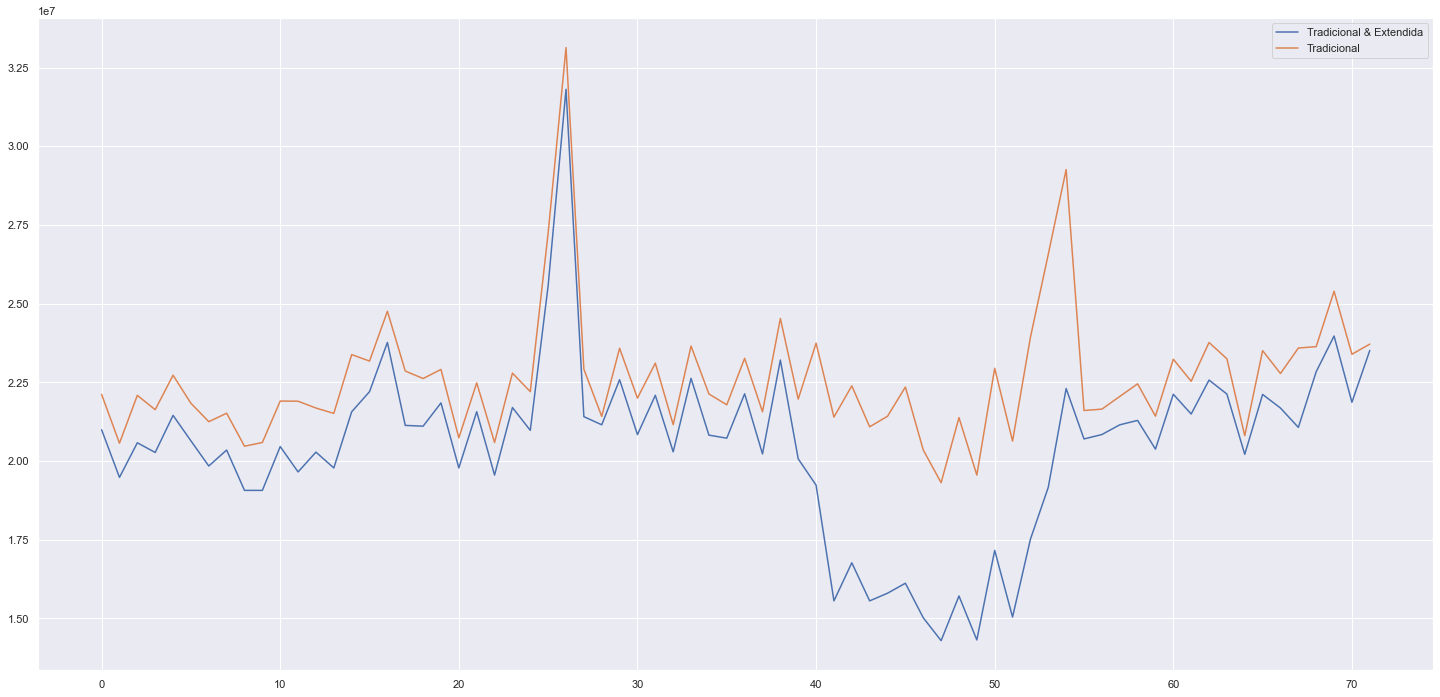

In [109]:
aux1 = df4[(df4['promo'] == 1) & (df4['promo2'] == 1)][['year_week', 'sales']].groupby('year_week').sum().reset_index()
ax = aux1.plot()

aux2 = df4[(df4['promo'] == 1) & (df4['promo2'] == 0)][['year_week', 'sales']].groupby('year_week').sum().reset_index()
aux2.plot(ax=ax)
ax.legend(labels=['Tradicional & Extendida', 'Tradicional']); 



### **H7.**Lojas abertas durante o feriado de Natal deveriam vender mais.
***FALSE*** Lojas abertas durante o feriado de Natal vendem MENOS.

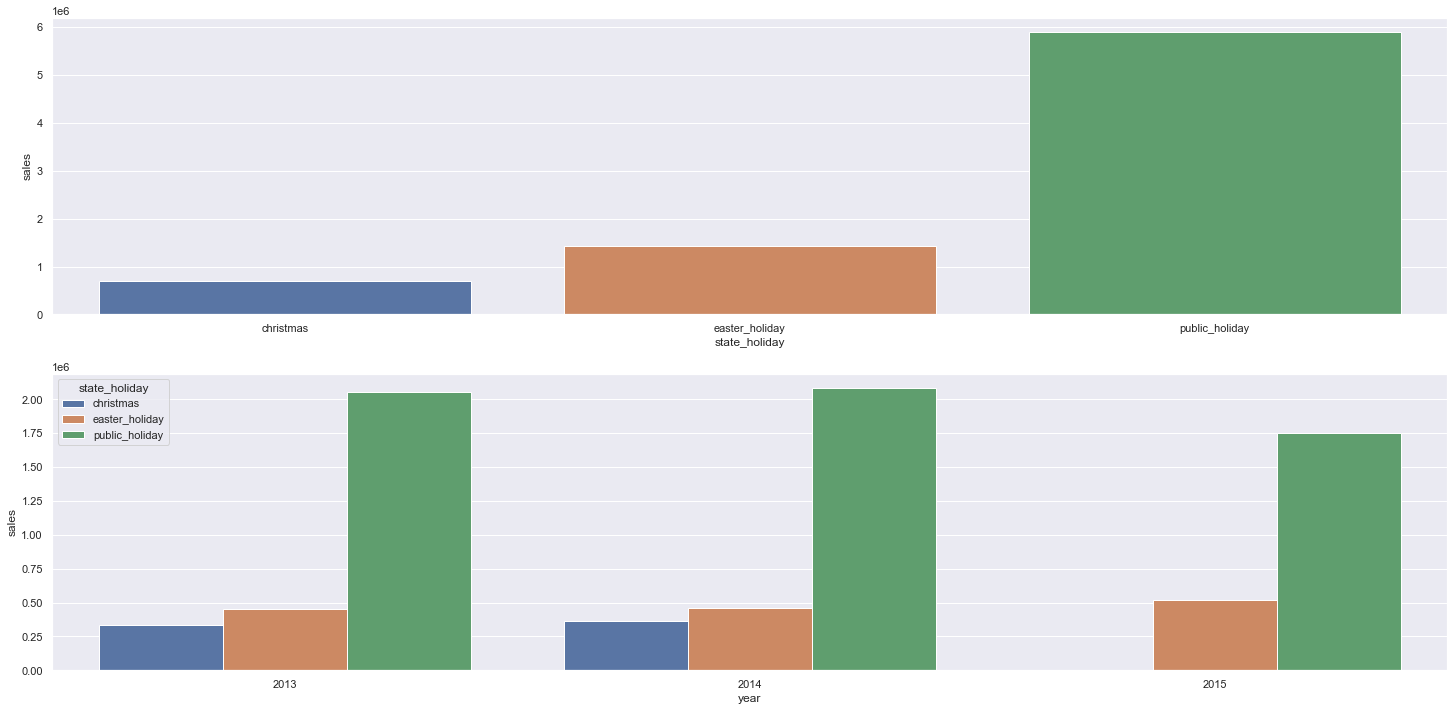

In [110]:
aux = df4[df4['state_holiday']!= 'regular_day']

aux1 = aux[['state_holiday', 'sales']].groupby('state_holiday').sum().reset_index()

plt.subplot(2, 1, 1 )
sns.barplot(x= 'state_holiday', y= 'sales', data=aux1)

plt.subplot(2, 1, 2 )
aux2 = aux[['year', 'state_holiday', 'sales']].groupby (['year', 'state_holiday']).sum().reset_index()
sns.barplot(x= 'year', y= 'sales', hue = 'state_holiday', data=aux2);



### **H8.** Lojas deveriam vender mais ao longo do anos.
***FALSE*** Lojas vendem MENOS ao longo dos anos.

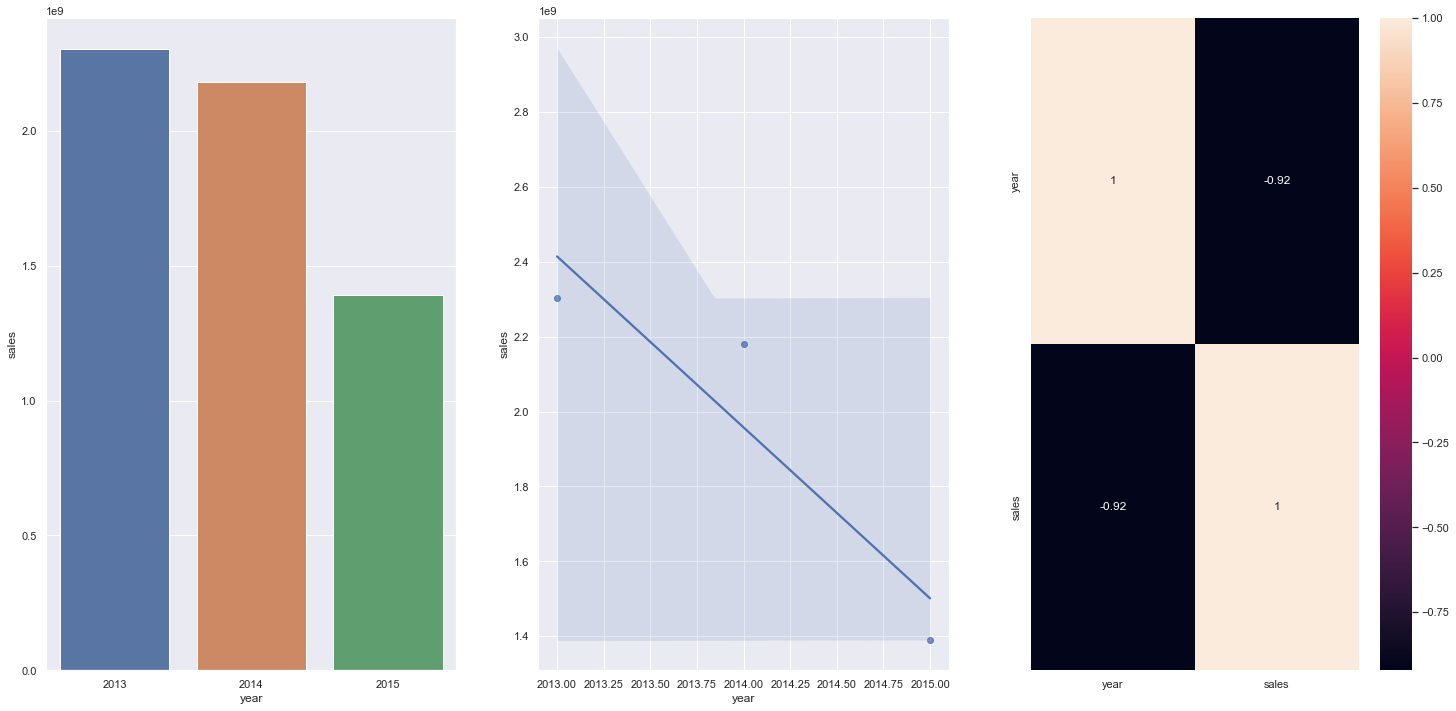

In [111]:
aux1 = df4[['year', 'sales']].groupby('year').sum().reset_index()

plt.subplot (1, 3, 1)
sns.barplot (x='year', y='sales', data=aux1)

plt.subplot (1, 3, 2)
sns.regplot (x='year', y='sales', data=aux1)

plt.subplot (1, 3, 3)
sns.heatmap (aux1.corr('pearson'), annot= True);




### **H9.** Lojas deveriam vender mais no segundo semestre do ano.
***FALSE*** Lojas vendem MENOS no segundo semestre do ano.

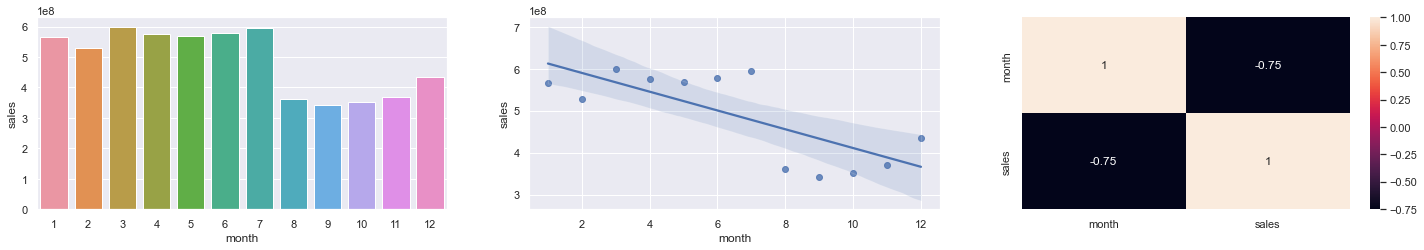

In [112]:
aux1 =df4[['month', 'sales']].groupby('month').sum().reset_index()

plt.subplot (3, 3, 1)
sns.barplot (x='month', y= 'sales', data=aux1)

plt.subplot (3, 3, 2)
sns.regplot (x='month', y='sales', data=aux1)

plt.subplot (3, 3, 3)
sns.heatmap (aux1.corr('pearson'), annot= True);





### **H10.** Lojas deveriam vender mais depois do dia 10 de cada mês.
***TRUE*** Lojas vendem MAIS depos do dia 10 de cada mês.

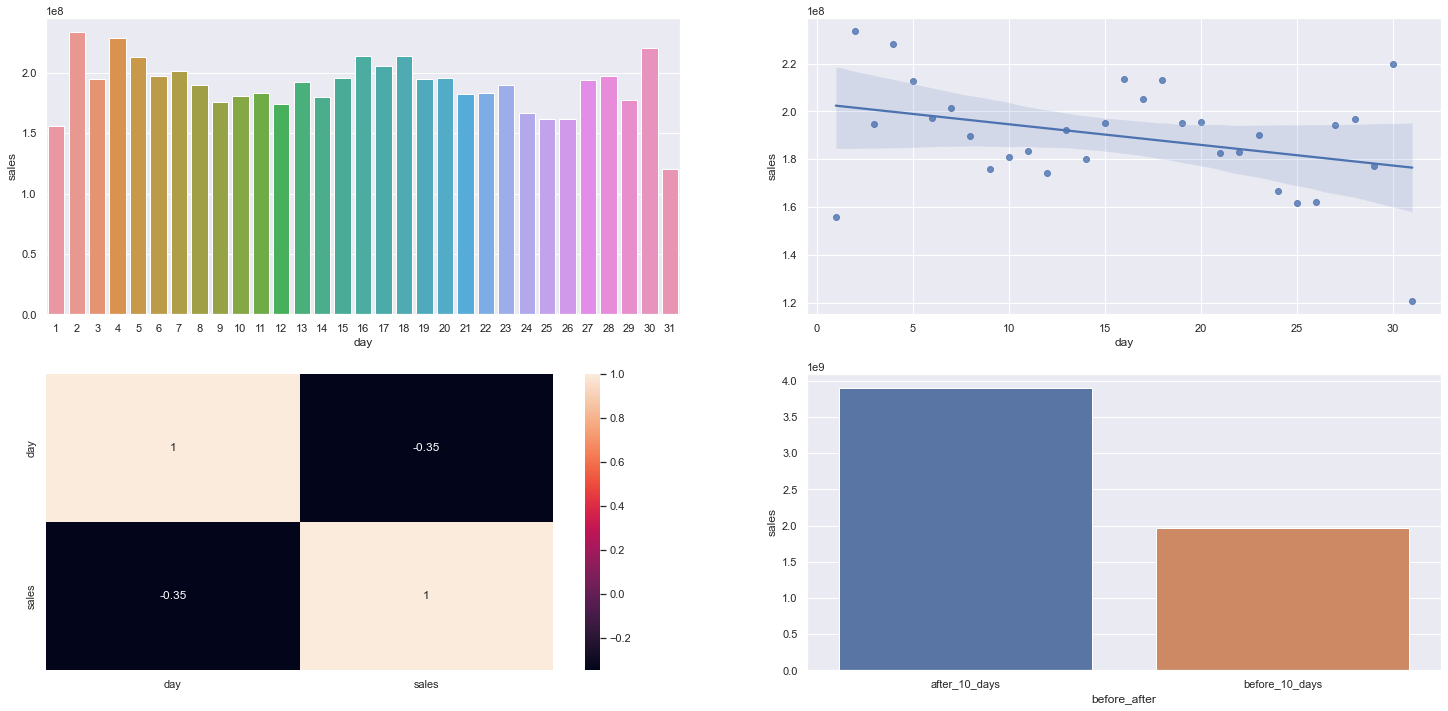

In [113]:
aux1 = df4[['day', 'sales']].groupby('day').sum().reset_index()

plt.subplot (2, 2, 1)
sns.barplot(x='day', y='sales', data=aux1);

plt.subplot (2, 2, 2)
sns.regplot (x='day', y='sales', data=aux1)

plt.subplot (2, 2, 3)
sns.heatmap (aux1.corr('pearson'), annot= True);


aux1['before_after'] = aux1['day'].apply(lambda x: 'before_10_days' if x <= 10 else 'after_10_days')

plt.subplot (2, 2, 4)
aux2 = aux1[['before_after', 'sales']].groupby('before_after').sum().reset_index()
sns.barplot(x='before_after', y= 'sales', data=aux2);


### **H11.** Lojas deveriam vender menos aos finais de semana.
***TRUE*** Lojas vendem menos aos finais de semana, principalmente domingo.

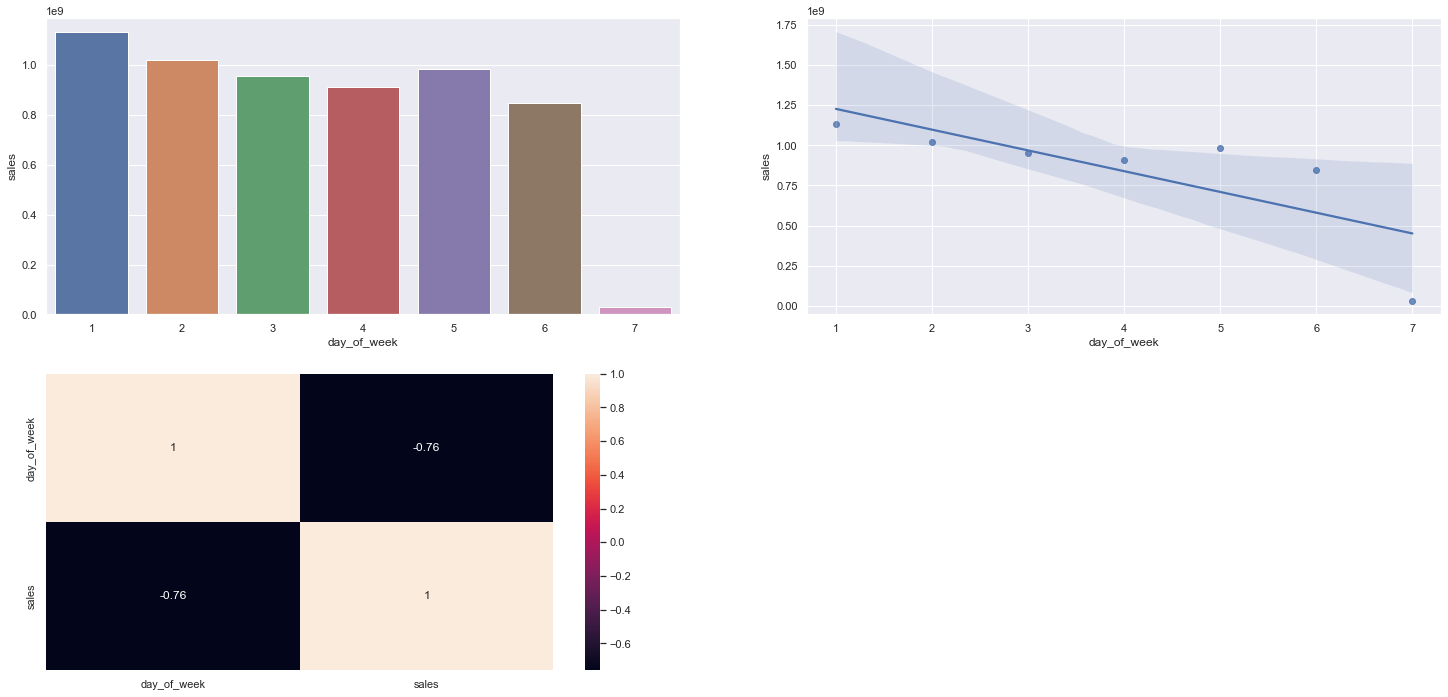

In [114]:
aux1 = df4[['day_of_week', 'sales']].groupby('day_of_week').sum().reset_index()

plt.subplot (2, 2, 1)
sns.barplot(x='day_of_week', y= 'sales', data=aux1);

plt.subplot (2, 2, 2)
sns.regplot(x='day_of_week', y= 'sales', data=aux1);

plt.subplot (2, 2, 3)
sns.heatmap(aux1.corr('pearson'), annot=True);



### **H12.** Lojas deveriam vender menos durante os feriados escolares.
***TRUE*** Lojas vendem MENOS durante os feriados escolares, exceto Julho e Agosto.

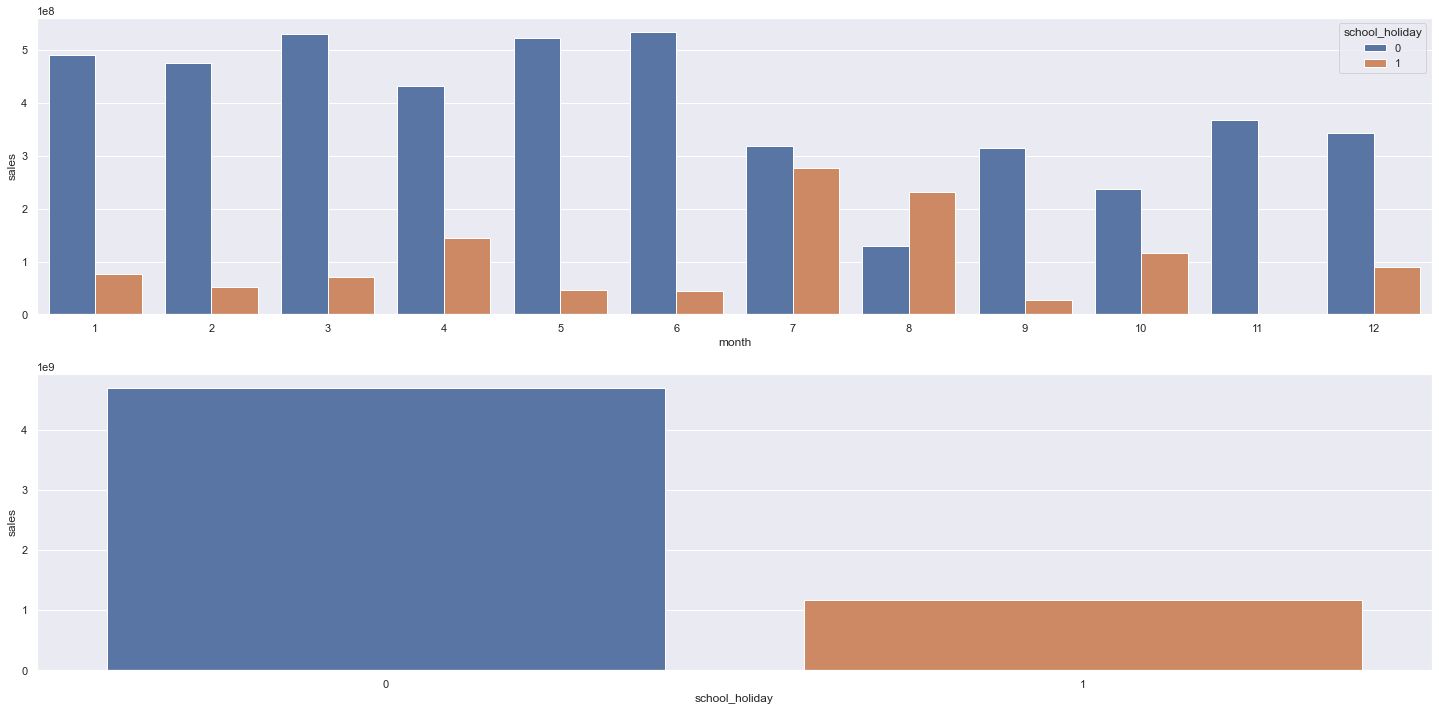

In [115]:
aux1 = df4[['school_holiday', 'sales']].groupby('school_holiday').sum().reset_index()
plt.subplot(2,1,2)
sns.barplot(x='school_holiday', y='sales', data=aux1);

plt.subplot(2,1,1)
aux2 = df4[['month', 'school_holiday', 'sales']].groupby(['month', 'school_holiday']).sum().reset_index()
sns.barplot(x='month', y='sales', hue='school_holiday', data=aux2);




## Resumo das Hipoteses 

In [116]:
tab = [['Hipoteses', 'Conclusão', 'Relevancia'], 
      ['H1', 'Falsa', 'Baixa'],
      ['H2', 'Falsa', 'Meida'],
      ['H3', 'Falsa', 'Media'],
      ['H4', 'Falsa', 'Baixa'],
      ['H5', '-', '-'],
      ['H6', 'Falsa', 'Baixa'],
      ['H7', 'Falsa', 'Media'],
      ['H8', 'Falsa', 'Alta'],
      ['H9', 'Falsa', 'Alta'],
      ['H10', 'Verdadeira', 'Alta'],
      ['H11', 'Verdadeira', 'Alta'],
      ['H12', 'Verdadeira', 'Baixa']
      ]
print(tabulate(tab,headers= 'firstrow'))

Hipoteses    Conclusão    Relevancia
-----------  -----------  ------------
H1           Falsa        Baixa
H2           Falsa        Meida
H3           Falsa        Media
H4           Falsa        Baixa
H5           -            -
H6           Falsa        Baixa
H7           Falsa        Media
H8           Falsa        Alta
H9           Falsa        Alta
H10          Verdadeira   Alta
H11          Verdadeira   Alta
H12          Verdadeira   Baixa


## 4.3 ANALISE MULTIVARIADA

### 4.3.1 Numercial Attributes

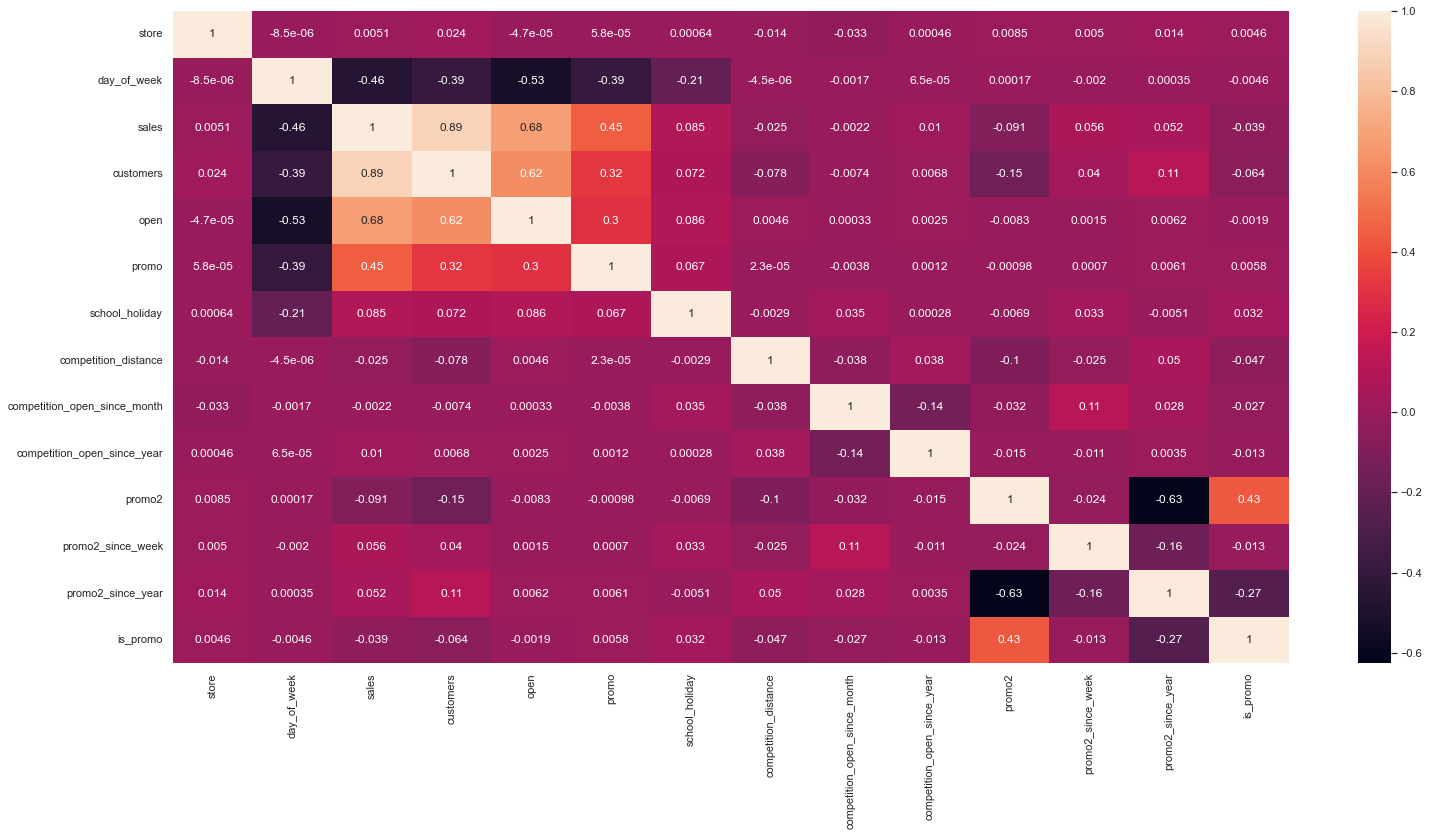

In [117]:
correlation = num_attributes.corr(method = 'pearson')
sns.heatmap(correlation, annot=True);

### 4.3.2 Categorical Attributes

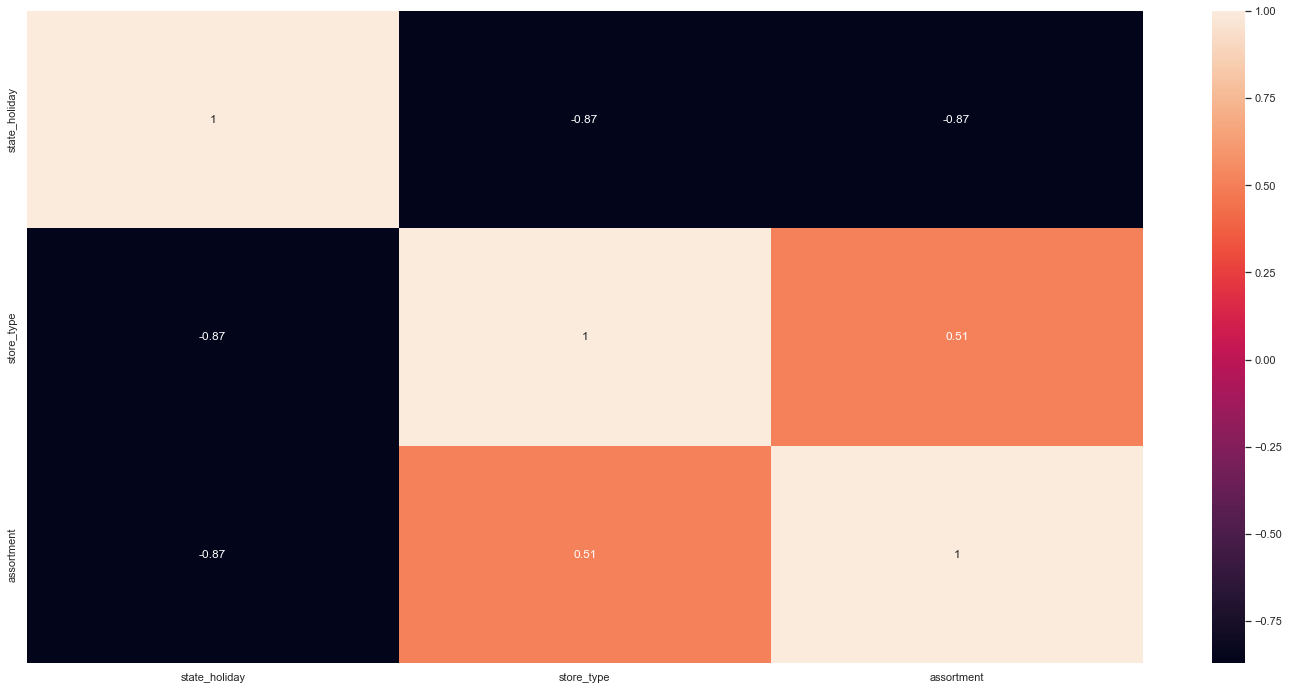

In [118]:
#only categorical data
a = df4.select_dtypes(include = 'object')

# Calculate Cramer V 
a1 = cramer_v(a['state_holiday'], a['state_holiday'])
a2 = cramer_v(a['state_holiday'], a['store_type'])
a3 = cramer_v(a['state_holiday'], a['assortment'])

a4 = cramer_v(a['store_type'], a['state_holiday'])
a5 = cramer_v(a['store_type'], a['store_type'])
a6 = cramer_v(a['store_type'], a['assortment'])

a7 = cramer_v(a['assortment'], a['state_holiday'])
a8 = cramer_v(a['assortment'], a['store_type'])
a9 = cramer_v(a['assortment'], a['assortment'])

# Final dataset
d = pd.DataFrame({'state_holiday': [a1, a2, a3],
             'store_type': [a4,a5,a6],
             'assortment': [a7,a8,a9]} )

d = d.set_index(d.columns)

sns.heatmap(d.corr(method = 'pearson'), annot = True);

# 5.0. PASSO 05 - DATA PREPARATION

In [119]:
df5 = df4.copy()

In [120]:
df5.shape

(844338, 25)

## 5.1. Normalização

In [121]:
# Não é feita já que todos as variaveis númericas não apresentam comportamento de normal.

## 5.2. Rescaling

In [122]:
rs = RobustScaler()
mms = MinMaxScaler() 

# competition_distance
df5['competition_distance'] = rs.fit_transform(df5[['competition_distance']].values)

# competition_time_month
df5['competition_time_month'] = rs.fit_transform(df5[['competition_time_month']].values)

# promo_time_week
df5['promo_time_week'] = mms.fit_transform(df5[['promo_time_week']].values)

# year
df5['year'] = mms.fit_transform(df5[['year']].values)


## 5.3. Transformação

### 5.3.1 Encoding

In [123]:
# state_holiday  - One hot encoding

df5 = pd.get_dummies(df5, prefix = ['state_holiday'], columns = ['state_holiday'])

# store_type - Label encoding

le = LabelEncoder()
df5['store_type'] = le.fit_transform(df5 ['store_type'] )

# assortment - Ordinal encoding
assortment_dict = {'basic': 1, 'extra': 2,'extended': 3}
df5['assortment'] = df5['assortment'].map(assortment_dict)



### 5.3.2 Responde Variable Transformation

In [124]:
df5['sales'] = np.log1p(df5 ['sales'])

### 5.3.3  Nature Transformation

In [125]:
# month
df5 ['month_sin']  = df5['month'].apply(lambda x: np.sin( x * ( 2. * np.pi/12 ) ) )
df5 ['month_cos '] = df5['month'].apply(lambda x: np.cos( x * ( 2. * np.pi/12 ) ) )

# day
df5 ['day_sin']  = df5['day'].apply(lambda x: np.sin( x * ( 2. * np.pi/30 ) ) )
df5 ['day_cos '] = df5['day'].apply(lambda x: np.cos( x * ( 2. * np.pi/30 ) ) )

# week_of_year
df5 ['week_of_year_sin']  = df5['week_of_year'].apply(lambda x: np.sin( x * ( 2. * np.pi/52 ) ) )
df5 ['week_of_year_cos '] = df5['week_of_year'].apply(lambda x: np.cos( x * ( 2. * np.pi/52 ) ) )

# day_of_week
df5 ['day_of_week_sin']  = df5['day_of_week'].apply(lambda x: np.sin( x * ( 2. * np.pi/7 ) ) )
df5 ['day_of_week_cos '] = df5['day_of_week'].apply(lambda x: np.cos( x * ( 2. * np.pi/7 ) ) )

In [126]:
df5.shape

(844338, 36)

# 6.0. PASSO 06 - FEATURE SELECTION

In [127]:
df6 = df5.copy()

## 6.1 Split data frame in test e trainning dataset

In [128]:
cols_drop = ['day_of_week', 'week_of_year', 'day', 'month', 'promo_since','competition_since', 'year_week']
df6 = df6.drop(cols_drop, axis = 1 )

In [129]:
df6.shape

(844338, 29)

In [130]:
# trainning dataset
X_train = df6[df6['date'] < '2015-06-19']
y_train = X_train['sales']

# test dataset
X_test = df6[df6['date'] >= '2015-06-19']
y_test = X_test['sales']

a = X_train['date'].min()
b = X_train['date'].max()
c = X_test['date'].min()
d = X_test['date'].max()

print(f'Tranning Min date {a}')
print(f'Tranning Max date {b}')

print(f'\nTest Min date {c}')
print(f'Test Max date {d}')



Tranning Min date 2013-01-01 00:00:00
Tranning Max date 2015-06-18 00:00:00

Test Min date 2015-06-19 00:00:00
Test Max date 2015-07-31 00:00:00


## 6.2 BORUTA as a Feature Selector

In [131]:
# # tranning and test dataset for boruta 
# X_train_n = X_train.drop( ['date', 'sales'], axis = 1).values
# y_train_n = y_train.values.ravel()

# # define RandomForestRegressor
# rf = RandomForestRegressor(n_jobs = -1)

# # define boruta 
# boruta = BorutaPy (rf, n_estimators= 'auto', verbose=2, random_state = 42).fit(X_train_n, y_train_n)

In [132]:
# cols_selected = boruta.support_.tolist()

# # best features
# X_train_fs = X_train.drop(['date', 'sales'], axis = 1)
# cols_selected_boruta = X_train_fs.iloc[:, cols_selected].columns.to_list()

# # not selected boruta 
# cols_not_selected_boruta = list (np.setdiif1d(x_train_fs.columns, cols_selected_boruta)) 

In [134]:
cols_not_selected_boruta = [ 'is_promo', 'month_sin', 'school_holiday', 'state_holiday_christmas'
                            'state_holiday_easter_holiday', 'state_holiday_public_holiday', 
                            'state_holiday_regular_day', 'week_of_year_sin', 'year']

## 6.3 Manual Feature Selection

In [138]:
cols_selected_boruta = [
    'store',
    'promo',
    'store_type',
    'assortment',
    'competition_distance',
    'competition_open_since_month',
    'competition_open_since_year',
    'promo2',
    'promo2_since_week',
    'promo2_since_year',
    'competition_time_month',
    'promo_time_week',
    'day_of_week_sin',
    'day_of_week_cos',
    'month_sin',
    'month_cos',
    'day_sin',
    'day_cos',
    'week_of_year_sin',
    'week_of_year_cos']

# columns to add
feat_to_add = ['date', 'sales']

#final features
cols_selected_boruta.extend (feat_to_add)

In [139]:
cols_selected_boruta

['store',
 'promo',
 'store_type',
 'assortment',
 'competition_distance',
 'competition_open_since_month',
 'competition_open_since_year',
 'promo2',
 'promo2_since_week',
 'promo2_since_year',
 'competition_time_month',
 'promo_time_week',
 'day_of_week_sin',
 'day_of_week_cos',
 'month_sin',
 'month_cos',
 'day_sin',
 'day_cos',
 'week_of_year_sin',
 'week_of_year_cos',
 'date',
 'sales']